# Moveworks Take-Home Assignment
#### Young Yoon (y.s.yoon@berkeley.edu), May 9, 2022

## 1. Objective
The required task is to detect anomalies in ambient temperatures of an office recorded in <a href = "https://github.com/numenta/NAB/blob/master/data/realKnownCause/ambient_temperature_system_failure.csv">this</a> dataset.

I structured this notebook based on the instructions, which can be found <a href = "https://drive.google.com/file/d/1G5R8lc056_wV2PFLgMpxivGfrIkE8k60/view?usp=sharing">here</a>.


## 2. Preparation
### 2.1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

### 2.2. Download and convert the csv file into a dataframe

In [2]:
# Download the csv file
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"
download = requests.get(url).content

# Read and convert the csv file into a dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

## 3. Question 1 - Explore
I conduct Exploratory Data Analysis (EDA) to better understand the data and plan the main analysis.

### 3.1. Explain the shape and characteristics of the data. 
Start the EDA by inspecting the shape and distribution of the data.

In [3]:
# Print the first 5 rows
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [4]:
# Print the shape of the data
df.shape

(7267, 2)

In [5]:
# Number of missing values
df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [6]:
# Empirical distribution of the temperature (value)
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [7]:
# Min and max of the timestamp
print("Timestamp min:", df.timestamp.min())
print("Timestamp max:", df.timestamp.max())

Timestamp min: 2013-07-04 00:00:00
Timestamp max: 2014-05-28 15:00:00


Several observations:
- The dataset has two variables - time (timestamp) and temperature (value); therefore, the dataset is a time-series dataset
- There are 7,267 observations
- Temperatures range from 57 to 86 degrees and do not have missing values
- The timestamp starts at '2013-07-04 00:00:00' and ends at '2014-05-28 15:00:00'
- Based on the timestamp, we can infer that the temperatures are recorded every hour or represent hourly mean or median values. I will assume that they are recorded at the beginning of each hour

### 3.2. Change data types
As shown below, the data type of timestamp is object. I am going to convert that to datetime.

In [8]:
# Display the information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [9]:
# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Confirm that the dates are correctly converted
print("Timestamp min:", df.timestamp.min())
print("Timestamp max:", df.timestamp.max())
print("Null values:", df.timestamp.isnull().sum())

Timestamp min: 2013-07-04 00:00:00
Timestamp max: 2014-05-28 15:00:00
Null values: 0



### 3.3. Use any visuals you see fit to explain the shape of the data.  Anything interesting you observe? Any other insights you discovered? 
In addition to the above, I would like to use some visuals to better understand the data.

#### 3.3.1. Temperature Histogram

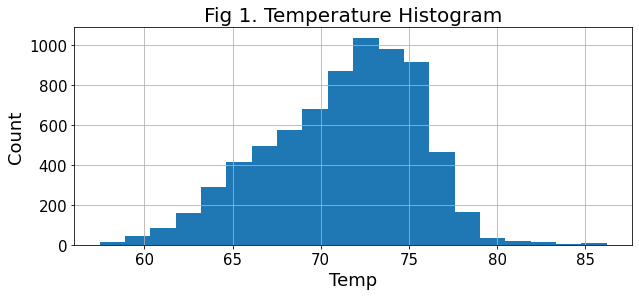

In [10]:
# Plot histogram of temperature
df.value.hist(bins = 20, figsize =(10, 4))               #Plot
plt.ylabel("Count", fontsize = 18)                       #Y label
plt.xlabel("Temp", fontsize = 18)                        #X label
plt.xticks(fontsize=15)                                  #X ticks
plt.yticks(fontsize=15)                                  #Y ticks
plt.title('Fig 1. Temperature Histogram', fontsize = 20) #Title
plt.show()

The histogram suggests that temperatures above 80 and below 60 could be anomalies.

#### 3.3.2. Plot the temperatures across timestamp
Since I am going to use the line plot several times, I am going to create a function for it.

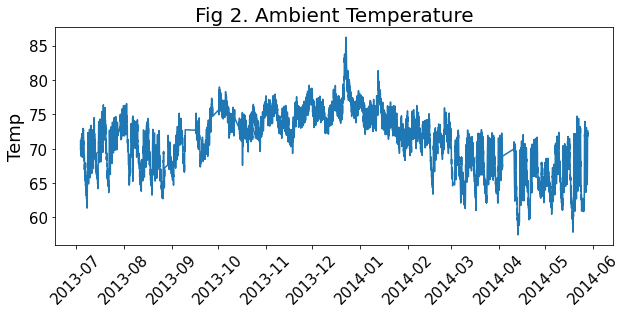

In [11]:
# Create a function to plot the time series
def plot_time_series (x, y, title):
    """ Plot the time-series of temperatures """
    # Generate the plot
    fig, ax = plt.subplots(1, 1, figsize=(10,4))        # Size
    ax.plot(x, y)                                       # Plot
    ax.set_title(title, size=20)                        # Title
    ax.set_ylabel('Temp', fontsize = 18)                # Y label
    ax.tick_params(axis='x', rotation=45, labelsize=15) # X tick rotate
    plt.yticks(fontsize=15)                             # Y tick size
    return(plt)

# Plot the temperatures across the entire sample period
plot_time_series(df.timestamp, df.value, 'Fig 2. Ambient Temperature')
plt.show()

The above plot provides a few insights:
1. There are spikes in temperatures throughout the time series
2. There seems to be an increasing trend followed by a decreasing trend. Such patterns suggest that we should try to remove the trends before proceeding with the analysis.
3. Flat lines suggest that there are some missing dates (e.g., mid-September in 2013)

#### 3.3.3. Temperatures in a restricted time window
To more closely inspect the data, I will examine the data within a month.

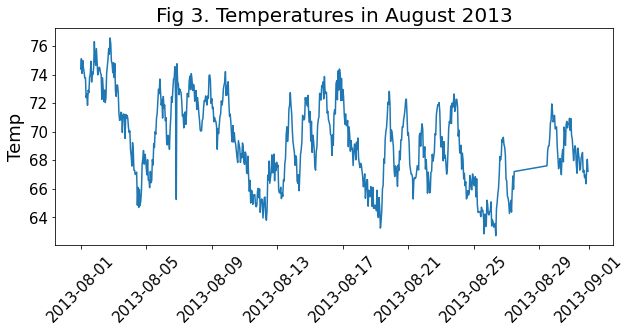

In [12]:
# Restrict the sample to August 2013
df_restricted = df.loc[(df.timestamp >= '2013-08-01 00:00:00')&
                       (df.timestamp < '2013-09-01 00:00:00')]

# Plot the temperatures across the restricted window
plot_time_series(df_restricted.timestamp, df_restricted.value, 'Fig 3. Temperatures in August 2013')
plt.show()

One additional insight from the above figure is that there are significant variations within each day and week. In addition, we can already visually see an anomaly point sometime between Aug 5th and Aug 9th.

### 3.4. What other types of exploratory analysis would you like to do?
Based on the above analysis, I would like to conduct the following analyses:
1. To remove the trends by taking the first difference
2. Identify systematic patterns within a day / week

## 4. Question 2 - Feature Engineering
### 4.1. What features would you like to build to extend the data set? 
As I indicated above, I would like to add the first difference in temperatures and a few variables to group temperatures by date and week.

### 4.2. Extend your data set with these new features you identified in the previous step. Explore your newly transformed data now. Anything interesting you observe?
#### 4.2.1. First difference

In [13]:
# New variable - First difference in temperatures
df['fd_value'] = df.value.diff()

# display the first 5 observations
df.head()

,timestamp,value,fd_value
0,2013-07-04 00:00:00,69.880835,NaN
1,2013-07-04 01:00:00,71.220227,1.339392
2,2013-07-04 02:00:00,70.877805,-0.342422
3,2013-07-04 03:00:00,68.959400,-1.918405
4,2013-07-04 04:00:00,69.283551,0.324151


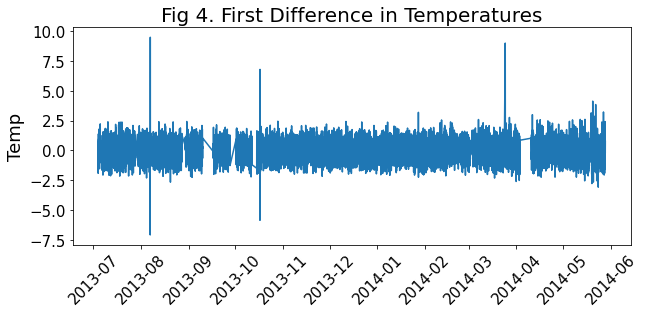

In [14]:
# Drop the first observation, which contains a missing value created by taking the first diff
df = df.dropna()

# Plot the temperatures across the restricted window
plot_time_series(df.timestamp, df.fd_value, 'Fig 4. First Difference in Temperatures')
plt.show()

The trends have been nicely removed. More importantly, we can see three anomalies very clearly.

#### 4.2.2. Create grouping variables
Fig. 3 above shows that there are significant variations within each week and each day. To examine whether there are systematic patterns within each week and each day, I will create grouping variables.

In [15]:
# Create variables for weekday and hour groupings
df['weekday'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour

# Disply the first 5 observations
df.head()

,timestamp,value,fd_value,weekday,hour
1,2013-07-04 01:00:00,71.220227,1.339392,3,1
2,2013-07-04 02:00:00,70.877805,-0.342422,3,2
3,2013-07-04 03:00:00,68.959400,-1.918405,3,3
4,2013-07-04 04:00:00,69.283551,0.324151,3,4
5,2013-07-04 05:00:00,70.060966,0.777415,3,5


#### 4.2.3. Examine weekday patterns
Compute average temperatures for each weekday and plot them.

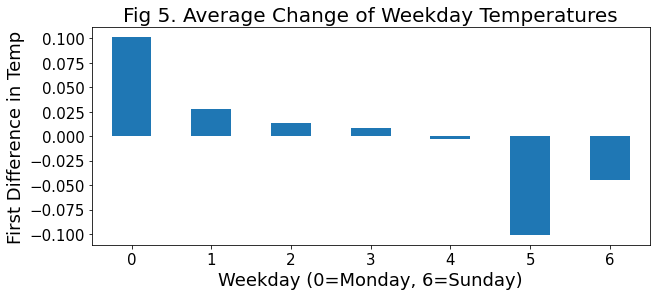

In [16]:
# Function to plot average temperatures
def plot_avg_temps (dataframe, group, var, title, xlabel):
    """ Plot the average temperatures across groups """
    # Compute the mean value for each group and generate the plot
    dataframe.groupby(by = group).mean()[var].plot(kind = "bar", figsize =(10, 4))
    
    # Plot settings
    plt.title(title, fontsize = 20)                       #Title
    plt.xticks(fontsize=15, rotation=0)                   #X ticks
    plt.yticks(fontsize=15)                               #Y ticks
    plt.ylabel("First Difference in Temp", fontsize = 18) #Y label
    plt.xlabel(xlabel, fontsize = 18)                     #X label

# Plot
plot_avg_temps(df, "weekday", "fd_value", 
               "Fig 5. Average Change of Weekday Temperatures", 
               "Weekday (0=Monday, 6=Sunday)")

Fig. 5 shows that temperatures tend to increase on weekday 0 (Mondays) and decrease on weekdays 5 and 6 (Saturdays and Sundays). This pattern makes economic sense.

#### 4.2.4. Examine hourly patterns
Compute average temperatures for each hour and plot them.

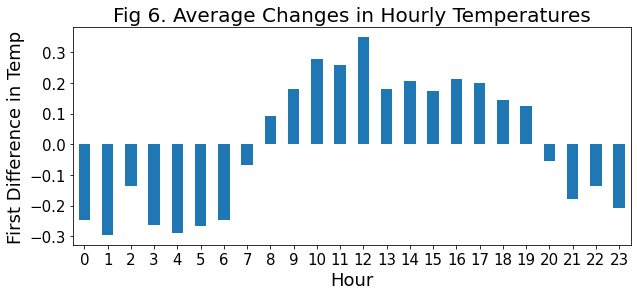

In [17]:
# Plot
plot_avg_temps(df, "hour", "fd_value", 
               "Fig 6. Average Changes in Hourly Temperatures", "Hour")

We can see from Fig. 6 that the average temperature change is positive during the day (8am - 7pm) and is negative during off-hours (8pm - 7 am). This pattern also makes sense because the dataset is a record of an office temperature.

#### 4.2.5. Demean the first difference in temperatures
One way to incorporate the systematic patterns in the temperature change is to compute demeaned values by subtracting out subgroup (weekday & hour) means.

In [18]:
# Compute the mean values of each group (weekday x hour)
group_mean = df.groupby(['weekday', 'hour'])['fd_value'].transform('mean')

# Demean
df['fd_value_demean'] = df['fd_value'] - group_mean
df.head()

,timestamp,value,fd_value,weekday,hour,fd_value_demean
1,2013-07-04 01:00:00,71.220227,1.339392,3,1,1.553210
2,2013-07-04 02:00:00,70.877805,-0.342422,3,2,-0.313377
3,2013-07-04 03:00:00,68.959400,-1.918405,3,3,-1.647166
4,2013-07-04 04:00:00,69.283551,0.324151,3,4,0.648724
5,2013-07-04 05:00:00,70.060966,0.777415,3,5,1.070370


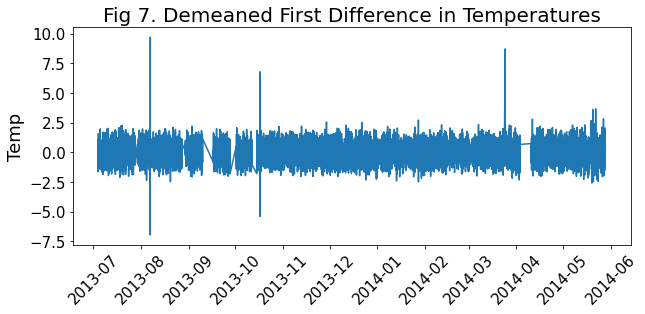

In [19]:
# Plot the demeaned first difference in Temperatures
plot_time_series(df.timestamp, df.fd_value_demean, 'Fig 7. Demeaned First Difference in Temperatures')
plt.show()

Fig. 7 isn't much different from Fig. 4. This is because the magnitudes of the average changes in weekday temperatures (Fig. 5) and those in hourly temperatures (Fig. 6) are not big enough to make a difference. Regardless, I am going to use the demeaned values (fd_value_demean) for the rest of the analysis.

## 5. Anomaly Detection - Visual Inspection
One way to identify anomalies is to visually inspect for anomaly points. In Fig 7. we can clearly see 3 anomalies (5 spikes). Let's get the timestamps for those anomalies.

In [20]:
# Create a binary variable that = 1 if abs(demeaned value) >= 5
df['anomaly_1_visual_inspect'] = (abs(df.fd_value_demean) >= 5).astype(int)

# Display the anomalies based on visual inspection
df[df.anomaly_1_visual_inspect==1]

,timestamp,value,fd_value,weekday,hour,fd_value_demean,anomaly_1_visual_inspect
780,2013-08-06 20:00:00,65.260177,-7.092303,1,20,-6.966571,1
781,2013-08-06 21:00:00,74.762234,9.502058,1,21,9.683679,1
2115,2013-10-16 22:00:00,67.592208,-5.863909,2,22,-5.401359,1
2116,2013-10-16 23:00:00,74.395906,6.803699,2,23,6.778264,1
5883,2014-03-24 19:00:00,71.943363,9.011588,0,19,8.705081,1


- Anomaly #1: Significant drop in temperature on 2013-08-06 at 20:00:00. It went back to normal within an hour.
- Anomaly #2: Significant drop in temperature on 2013-10-16 at 22:00:00. It went back to normal within an hour.
- Anomaly #3: Significant increase in temperature on 2013-10-16 at 22:00:00. It didn't revert back to a normal temperature right away since we do not see a sudden drop in temperature afterward.

Note that a significant increase following a significant drop in temperature shouldn't be considered an anomalous point because the change means that the temperature reverted back to a normal level.

If our client's main goal is to minimize making a Type I error, then we can stop the analysis here and conclude that those 3 points are anomaly points. However, I am going to assume that Type II errors are also important and thus will try to find more anomaly candidates.

## 6. Question 3. Anomaly Detection - Statistical Model
There are three common ways to identify anomalies: (1) Histogram, (2) Z-Score, and (3) Box plot. 

### 6.1. Anomaly Detection - Histogram
Plot a histogram for the first difference in temperatures.

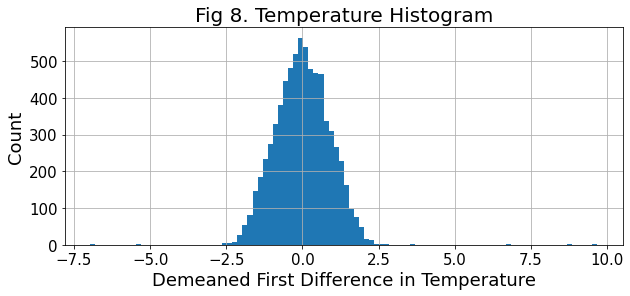

In [21]:
# Plot
df.fd_value_demean.hist(bins = 100, figsize =(10, 4)) #Plot
plt.ylabel("Count", fontsize = 18)                    #Y label
plt.xlabel("Demeaned First Difference in Temperature", fontsize = 18)                     #X label
plt.xticks(fontsize=15)                               #X ticks
plt.yticks(fontsize=15)                               #Y ticks
plt.title('Fig 8. Temperature Histogram', fontsize = 20)     #Title
plt.show()

There are a few anomalies both above and below 2.5. Let's record them as anomalies.

In [22]:
# Create a binary variable that = 1 if abs(demeaned value) >= 2.5
df['anomaly_2_histogram'] = (abs(df.fd_value_demean) >= 2.5).astype(int)

# Display the anomalies identified based on histogram
df[df.anomaly_2_histogram==1]

,timestamp,value,fd_value,weekday,hour,fd_value_demean,anomaly_1_visual_inspect,anomaly_2_histogram
780,2013-08-06 20:00:00,65.260177,-7.092303,1,20,-6.966571,1,1
781,2013-08-06 21:00:00,74.762234,9.502058,1,21,9.683679,1,1
2115,2013-10-16 22:00:00,67.592208,-5.863909,2,22,-5.401359,1,1
2116,2013-10-16 23:00:00,74.395906,6.803699,2,23,6.778264,1,1
3149,2013-11-29 00:00:00,79.025913,2.217068,4,0,2.546243,0,1
3697,2013-12-21 20:00:00,82.289240,2.392365,5,20,2.512748,0,1
4578,2014-01-27 13:00:00,74.466636,3.199618,0,13,2.715032,0,1
5883,2014-03-24 19:00:00,71.943363,9.011588,0,19,8.705081,1,1
6132,2014-04-11 09:00:00,65.375656,3.004512,4,9,2.788648,0,1
7046,2014-05-19 11:00:00,66.461085,3.155431,0,11,2.654848,0,1


### 6.2. Anomaly Detection - Z-Score
In order to use the Z-Score, we first need to make sure that the underlying data follows a normal distribution. Fig 8. above confirms that our variable is indeed normally distributed. Thus, we can proceed with the analysis.

Z score is defined as below.
<img src = "https://github.com/youngdataspace/Detect-Outliers-Using-Isolation-Forest/blob/main/Z%20Score.JPG?raw=true">

I will assume that any temperatures that have a Z-score less than or greater than 3 are anomalies.

In [23]:
# Compute Z-scores
zscores = (df.fd_value_demean - np.mean(df.fd_value_demean)) / np.std(df.fd_value_demean)

# Classify a temperature as an anomaly if the abs(Z-score) > 3
df['anomaly_3_zscore'] = (abs(zscores) >= 3).astype(int)

# Display the anomalies identified based on z scores
df[df.anomaly_3_zscore==1]

,timestamp,value,fd_value,weekday,hour,fd_value_demean,anomaly_1_visual_inspect,anomaly_2_histogram,anomaly_3_zscore
780,2013-08-06 20:00:00,65.260177,-7.092303,1,20,-6.966571,1,1,1
781,2013-08-06 21:00:00,74.762234,9.502058,1,21,9.683679,1,1,1
2115,2013-10-16 22:00:00,67.592208,-5.863909,2,22,-5.401359,1,1,1
2116,2013-10-16 23:00:00,74.395906,6.803699,2,23,6.778264,1,1,1
4578,2014-01-27 13:00:00,74.466636,3.199618,0,13,2.715032,0,1,1
5883,2014-03-24 19:00:00,71.943363,9.011588,0,19,8.705081,1,1,1
6132,2014-04-11 09:00:00,65.375656,3.004512,4,9,2.788648,0,1,1
7070,2014-05-20 11:00:00,67.542172,4.141307,1,11,3.601871,0,1,1
7116,2014-05-22 09:00:00,69.101674,3.855127,3,9,3.652240,0,1,1
7237,2014-05-27 10:00:00,70.100104,3.230225,1,10,2.814732,0,1,1


### 6.3. Anomaly Detection - IQR
We can also use Inter Quartile Range (IQR) to identify anomalies. IQR refers to the difference between the third quartile (Q3) and the first quartile (Q1). The rule of thumb is to consider any observations that are below 1.5 x IQR from the first quartile and above 1.5 x IQR from the third quartile as anomalies.

In [24]:
# Calculate Q1 and Q3
q1, q3= df.fd_value_demean.quantile(0.25), df.fd_value_demean.quantile(0.75)

# Calculate IQR
iqr = q3-q1

# Print Lower and upper limit, q1, q3, and iqr
print("Q1:          ", q1)
print("Q3:          ", q3)
print("IQR:         ", iqr)
print("Lower limit: ",  q1 - 1.5* iqr)
print("Upper limit: ",  q3 + 1.5* iqr)

Q1:           -0.6072221440299335
Q3:           0.6042492545787184
IQR:          1.2114713986086518
Lower limit:  -2.424429241942911
Upper limit:  2.4214563524916963


The above shows that the lower and upper limits are around -2.42 and 2.42, respectively. I am going to use those thresholds to identify anomalies.

In [25]:
# Classify a temperature as an anomaly if the abs(Z-score) > 3
df['anomaly_4_iqr'] = (abs(zscores) >= 2.42).astype(int)

# Display the first 5 anomalies identified based on IQR
df[df.anomaly_4_iqr==1].head(5)

,timestamp,value,fd_value,weekday,hour,fd_value_demean,anomaly_1_visual_inspect,anomaly_2_histogram,anomaly_3_zscore,anomaly_4_iqr
354,2013-07-18 18:00:00,76.390019,2.379381,3,18,2.214106,0,0,0,1
374,2013-07-19 14:00:00,75.327741,2.380400,4,14,2.250514,0,0,0,1
723,2013-08-04 11:00:00,64.861275,-2.309871,6,11,-2.361095,0,0,0,1
780,2013-08-06 20:00:00,65.260177,-7.092303,1,20,-6.966571,1,1,1,1
781,2013-08-06 21:00:00,74.762234,9.502058,1,21,9.683679,1,1,1,1


Box plots are a great way to visualize IQR and anomalies.

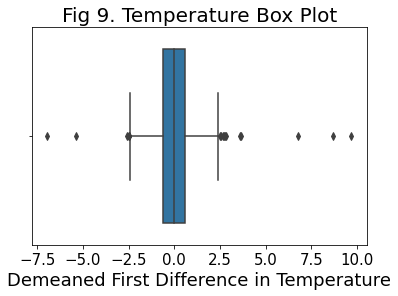

In [26]:
# Generate a box plot
sns.boxplot(x = 'fd_value_demean', data = df)
plt.xlabel("Demeaned First Difference in Temperature", fontsize = 18)                     #X label
plt.xticks(fontsize=15)                               #X ticks
plt.title('Fig 9. Temperature Box Plot', fontsize = 20)     #Title
plt.show()

## 7. Question 4. Anomaly Detection - Clustering (DBSCAN)
One of the popular clustering algorithms for anomaly detection is Density-Based Spatial Clustering of Applications with Noise (DBSCAN). It takes two hyperparameters--epsilon and minimum sample--and clusters the data. Epsilon is the radius of the circle created around each data point. Minimum sample is the minimum number of observations required within the circle to be classified as a Core point.

Due to time constaint, I am going to use the default values (eps = 0.5, min_samples = 5).

In [27]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Create a new dataframe
df_dbscan = df[["fd_value_demean"]]

# Train the model
model = DBSCAN(eps = 0.5, min_samples = 5).fit(df_dbscan)

# Extract predictions (outputs -1 for outliers)
df['anomaly_5_dbscan'] = (model.labels_==-1).astype(int)

# Display the anomalies identified based on DBSCAN
df[df.anomaly_5_dbscan==1]

,timestamp,value,fd_value,weekday,hour,fd_value_demean,anomaly_1_visual_inspect,anomaly_2_histogram,anomaly_3_zscore,anomaly_4_iqr,anomaly_5_dbscan
780,2013-08-06 20:00:00,65.260177,-7.092303,1,20,-6.966571,1,1,1,1,1
781,2013-08-06 21:00:00,74.762234,9.502058,1,21,9.683679,1,1,1,1,1
2115,2013-10-16 22:00:00,67.592208,-5.863909,2,22,-5.401359,1,1,1,1,1
2116,2013-10-16 23:00:00,74.395906,6.803699,2,23,6.778264,1,1,1,1,1
5883,2014-03-24 19:00:00,71.943363,9.011588,0,19,8.705081,1,1,1,1,1
7070,2014-05-20 11:00:00,67.542172,4.141307,1,11,3.601871,0,1,1,1,1
7116,2014-05-22 09:00:00,69.101674,3.855127,3,9,3.652240,0,1,1,1,1


## 8. Question 5. Anomaly Detection - Classification (Isolation Forest)
Isolation Forest is a tree ensemble method of detecting anomalies first proposed by Liu, Ting, and Zhou (2008). Unlike other methods that first try to understand the normal points and classify abnormal points as anomalies, Isolation Forest explicitly isolates anomalies.

Anomalies have two characteristics. They are distanced from normal points and there are only a few of them. The Isolation Forest algorithm exploits these two characteristics. The algorithm takes the percentage of anomalies (i.e., contamination rate) as a hyperparameter. For this assignment, I will choose the contamination rate of 0.5%.

For more details on the algorithm, see <a href = "https://medium.com/@y.s.yoon/isolation-forest-anomaly-detection-identify-outliers-101123a9ff63">my blog post</a>.



In [28]:
# Import Isolation Forest
from sklearn.ensemble import IsolationForest

# Create a data frame only with fd_value_demean and convert it to an array
df_isf = df[["fd_value_demean"]].values

# Train the model
isf = IsolationForest(contamination=0.005)
isf.fit(df_isf)

# Predictions
predictions = isf.predict(df_isf)

# Extract predictions (outputs -1 for outliers)
df['anomaly_6_iso'] = (predictions==-1).astype(int)

# Display the first 5 anomalies identified based on Isolation Forest
df[df.anomaly_6_iso==1].head(5)

,timestamp,value,fd_value,weekday,hour,fd_value_demean,anomaly_1_visual_inspect,anomaly_2_histogram,anomaly_3_zscore,anomaly_4_iqr,anomaly_5_dbscan,anomaly_6_iso
354,2013-07-18 18:00:00,76.390019,2.379381,3,18,2.214106,0,0,0,1,0,1
374,2013-07-19 14:00:00,75.327741,2.380400,4,14,2.250514,0,0,0,1,0,1
723,2013-08-04 11:00:00,64.861275,-2.309871,6,11,-2.361095,0,0,0,1,0,1
780,2013-08-06 20:00:00,65.260177,-7.092303,1,20,-6.966571,1,1,1,1,1,1
781,2013-08-06 21:00:00,74.762234,9.502058,1,21,9.683679,1,1,1,1,1,1


## 9. Present the Findings
### 9.1. List
For each anomaly detection method, I already created a binary variable that takes 1 for identified anomalies. Using these variables, I can easily filter and export the data with timestamps. Below shows an example of the anomalies identified using the Isolation Forest method.

In [37]:
# Only leave anomalies identified using the Isolation Forest algorithm
df[df.anomaly_6_iso==1][['timestamp', 'value', 'anomaly_6_iso']]

,timestamp,value,anomaly_6_iso
354,2013-07-18 18:00:00,76.390019,1
374,2013-07-19 14:00:00,75.327741,1
723,2013-08-04 11:00:00,64.861275,1
780,2013-08-06 20:00:00,65.260177,1
781,2013-08-06 21:00:00,74.762234,1
1094,2013-08-19 22:00:00,69.320895,1
2115,2013-10-16 22:00:00,67.592208,1
2116,2013-10-16 23:00:00,74.395906,1
3149,2013-11-29 00:00:00,79.025913,1
3452,2013-12-11 15:00:00,74.586666,1


### 9.2. Plots
If I were to present my results, I would use plots and highlight all the anomalies. The next set of figures presents anomalies identified using each method.

As mentioned above, a significant increase (decrease) following a significant drop (increase) in temperature shouldn't be considered an anomalous point in most cases. This is because the change could mean that the temperature reverted back to a normal level.

#### 9.2.1. Plot Function
Since I am going to generate many plots, I will first create a function.

In [30]:
# Plot function
def plot_anomalies(x, y, title, anomaly_column):
    """ Plot the time series and highlight anomalies """
    # Generate the plot
    fig, ax = plt.subplots(1, 1, figsize=(10,4))                  # Size
    ax.plot(
        x, y,           
        marker='D', mec='red', mfc='red', 
        markevery = np.where(df[anomaly_column]==1, True, False)) # Plot & highlight
    ax.set_title(title, size=20)                                  # Title
    ax.set_ylabel('Temp', fontsize = 18)                          # Y label
    ax.tick_params(axis='x', rotation=45, labelsize=15)           # X tick rotate
    plt.yticks(fontsize=15)                                       # Y tick size
    return(plt)

#### 9.2.2. Plot anomalies identified by visual inspection

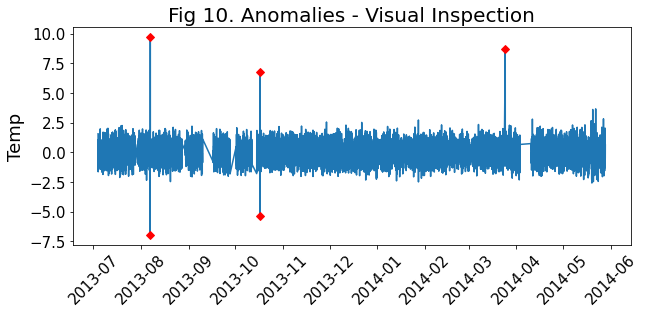

In [31]:
plot_anomalies(df.timestamp, df.fd_value_demean, 
                 'Fig 10. Anomalies - Visual Inspection', 
                 'anomaly_1_visual_inspect')
plt.show()

#### 9.2.3. Plot anomalies identified using the Histogram method

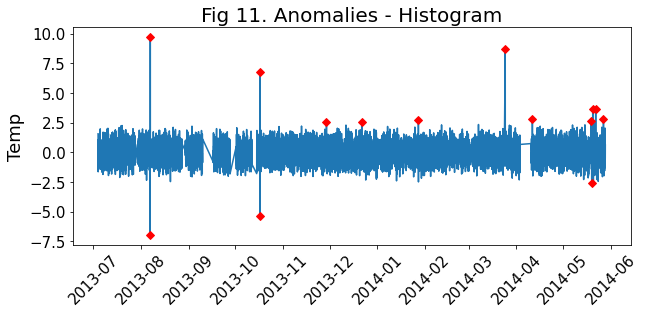

In [32]:
plot_anomalies(df.timestamp, df.fd_value_demean, 
                 'Fig 11. Anomalies - Histogram', 
                 'anomaly_2_histogram')
plt.show()

#### 9.2.4. Plot anomalies identified using the Z-Score method

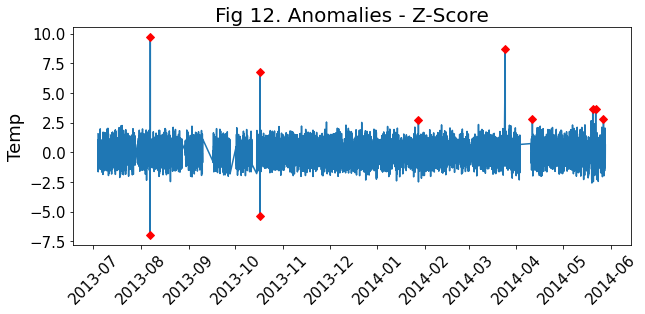

In [33]:
plot_anomalies(df.timestamp, df.fd_value_demean, 
                 'Fig 12. Anomalies - Z-Score', 
                 'anomaly_3_zscore')
plt.show()

#### 9.2.5. Plot anomalies identified using the IQR method

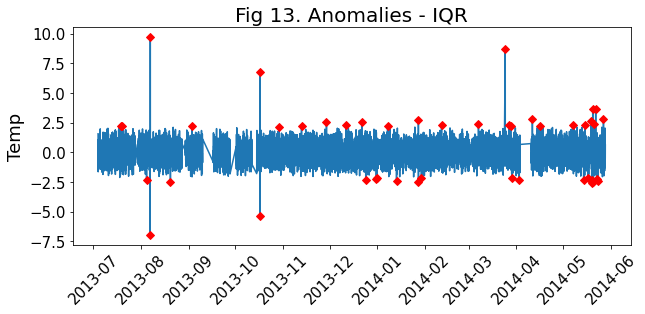

In [34]:
plot_anomalies(df.timestamp, df.fd_value_demean, 
                 'Fig 13. Anomalies - IQR', 
                 'anomaly_4_iqr')
plt.show()

#### 9.2.6. Plot anomalies identified using the DBSCAN method

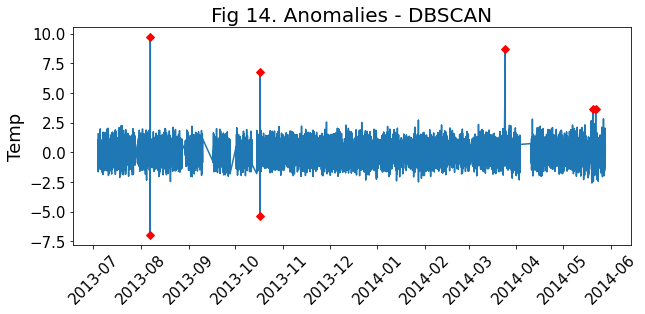

In [35]:
plot_anomalies(df.timestamp, df.fd_value_demean, 
                 'Fig 14. Anomalies - DBSCAN', 
                 'anomaly_5_dbscan')
plt.show()

#### 9.2.7. Plot anomalies identified using the Isolation Forest method

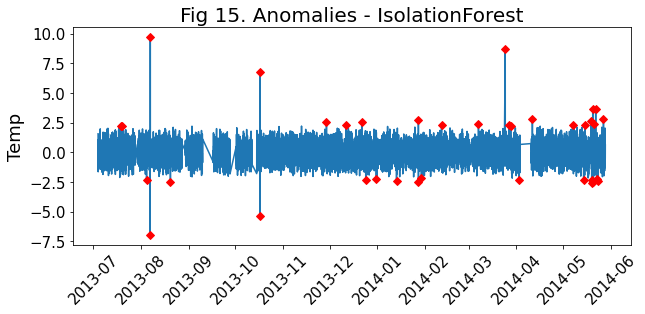

In [36]:
plot_anomalies(df.timestamp, df.fd_value_demean, 
                 'Fig 15. Anomalies - IsolationForest', 
                 'anomaly_6_iso')
plt.show()

## 10. Conclusion
In this assignment, I covered various methods to detect anomalies. As shown in the last section, all the methods performed similarly in that they all identified dates that are sticking out from the general deviation. Due to the time constraint, I wasn't able to tune hyperparameters. But in reality, one should spend a bit more time and tune hyperparameters to find an optimal point that has a good balance between Type I and Type II errors.